In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import os
from numpy import ma
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import datetime
from datetime import tzinfo

In [2]:
%matplotlib ipympl

In [3]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [4]:
def dereference(sel, ref, data=None, region=None, mask=None, ref_direction=(0,1), indices_only=False, as_masked=True):
    '''
        Load ``data`` referred to by ``ref`` that corresponds to the desired
        positions specified in ``sel``.

        :param sel: iterable of indices, an index, or a ``slice`` to match against ``ref[:,ref_direction[0]]``. Return value will have same first dimension as ``sel``, e.g. ``dereference(slice(100), ref, data).shape[0] == 100``

        :param ref: a shape (N,2) ``h5py.Dataset`` or array of pairs of indices linking ``sel`` and ``data``

        :param data: a ``h5py.Dataset`` or array to load dereferenced data from, can be omitted if ``indices_only==True``

        :param region: a 1D ``h5py.Dataset`` or array with a structured array type of [('start','i8'), ('stop','i8')]; 'start' defines the earliest index within the ``ref`` dataset for each value in ``sel``, and 'stop' defines the last index + 1 within the ``ref`` dataset (optional). If a ``h5py.Dataset`` is used, the ``sel`` spec will be used to load data from the dataset (i.e. ``region[sel]``), otherwise ``len(sel) == len(region)`` and a 1:1 correspondence is assumed

        :param mask: mask off specific items in selection (boolean, True == don't dereference selection), len(mask) == len(np.r_[sel])

        :param ref_direction: defines how to interpret second dimension of ``ref``. ``ref[:,ref_direction[0]]`` are matched against items in ``sel``, and ``ref[:,ref_direction[1]]`` are indices into the ``data`` array (``default=(0,1)``). So for a simple example: ``dereference([0,1,2], [[1,0], [2,1]], ['A','B','C','D'], ref_direction=(0,1))`` returns an array equivalent to ``[[],['A'],['B']]`` and ``dereference([0,1,2], [[1,0], [2,1]], ['A','B','C','D'], ref_direction=(1,0))`` returns an array equivalent to ``[['B'],['C'],[]]``

        :param indices_only: if ``True``, only returns the indices into ``data``, does not fetch data from ``data``

        :returns: ``numpy`` masked array (or if ``as_masked=False`` a ``list``) of length equivalent to ``sel``
    '''

    # set up selection
    sel_mask = mask
    sel_idcs = np.r_[sel][~sel_mask] if sel_mask is not None else np.r_[sel]
    n_elem = len(sel_idcs) if sel_mask is None else len(sel_mask)

    return_dtype = data.dtype if not indices_only else ref.dtype

    if not len(sel_idcs) and n_elem:
        # special case for if there is nothing selected in the mask
        if as_masked:
            return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True, shrink=False)
        else:
            return [np.empty(0, data.dtype) for _ in range(n_elem)]
    elif not len(sel_idcs):
        if as_masked:
            return ma.array(np.empty((0,1), dtype=return_dtype), mask=True, shrink=False)
        else:
            return []

    # load fast region lookup
    if region is not None:
        if isinstance(region, h5py.Dataset):
            if isinstance(sel, slice):
                region = region[sel] # load parent reference region information
            else:
                region_offset = np.min(sel_idcs)
                region_sel = slice(region_offset, int(np.max(sel_idcs)+1))
                region = region[region_sel][sel_idcs - region_offset]
        else:
            region = region[sel_idcs]

    # load relevant references
    region_valid = region['start'] != region['stop'] if region is not None else None
    if not region is None and np.count_nonzero(region_valid) == 0:
        # special case for if there are no valid references
        if as_masked:
            return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True)
        else:
            return [np.empty(0, return_dtype) for _ in range(n_elem)]
    ref_offset = np.min(region[region_valid]['start']) if region is not None else 0
    ref_sel = slice(ref_offset, int(np.max(region[region_valid]['stop']))) if region is not None else slice(ref_offset,len(ref))
    ref = ref[ref_sel]

    # if no valid references, return
    if len(ref) == 0:
        if as_masked:
            return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True)
        else:
            return [np.empty(0, return_dtype) for _ in range(n_elem)]

    # load relevant data
    dset_offset = np.min(ref[:,ref_direction[1]])
    dset_sel = slice(dset_offset, int(np.max(ref[:,ref_direction[1]])+1))
    dset = data[dset_sel] if not indices_only else None # load child dataset region

    # create a region array, if one was not given
    if region is None:
        region = np.zeros(len(sel_idcs), dtype=ref_region_dtype)
        region['start'] = ref_sel.start
        region['stop'] = ref_sel.stop

    if not as_masked:
        # dump into list using subregion masks
        if indices_only:
            indices = [
                    ref[st:sp,ref_direction[1]][ (ref[st:sp,ref_direction[0]] == i) ]
                    for i,st,sp in zip(sel_idcs, region['start']-ref_offset, region['stop']-ref_offset)
                ]
            return indices
        else:
            data = [
                    dset[ref[st:sp,ref_direction[1]][ (ref[st:sp,ref_direction[0]] == i) ] - dset_offset]
                    for i,st,sp in zip(sel_idcs, region['start']-ref_offset, region['stop']-ref_offset)
                ]
            return data


    # the rest of this is index manipulation to convert from sel -> ref -> data
    # first using only the unique references and then casting it back into the
    # original selection

    # first get mapping from unique selection back into the selection
    uniq_sel, uniq_inv = np.unique(sel_idcs, return_inverse=True)

    # only use references that are relevant to the selection
    ref_mask = np.isin(ref[:,ref_direction[0]], uniq_sel)
    if not np.any(ref_mask):
        # special case if no valid references for selection
        return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True, shrink=False)

    # get the number of references per parent and rearrange so that references are in ordered by parent
    uniq, counts = np.unique(ref[ref_mask,ref_direction[0]], return_counts=True)
    reordering = np.argsort(uniq)
    uniq, counts = uniq[reordering], counts[reordering]
    max_counts = np.max(counts)

    # now, we'll fill a subarray consisting of unique elements that were requested (shape: (len(uniq_sel), max_counts) )
    # get a mapping from the unique selection into the unique reference parents
    _,uniq_sel_idcs,uniq2uniq_sel_idcs = np.intersect1d(uniq_sel, uniq, assume_unique=False, return_indices=True)

    # set up subarrays for unique selection
    shape = (len(uniq_sel), max_counts)
    condensed_data = np.zeros(shape, dtype=return_dtype)
    condensed_mask = np.zeros(shape, dtype=bool)

    # block off and prepare slots for unique selection
    condensed_mask[uniq_sel_idcs] = np.arange(condensed_data.shape[1]).reshape(1,-1) < counts[uniq2uniq_sel_idcs].reshape(-1,1)
    view_dtype = np.dtype([('ref0',ref.dtype),('ref1',ref.dtype)])
    sort_ref = np.argsort(ref[ref_mask].view(view_dtype), axis=0,
        order=[view_dtype.names[ref_direction[0]], view_dtype.names[ref_direction[1]]]
        ) # arrange by parent (then by child)
    # and fill slots
    if indices_only:
        np.place(condensed_data, mask=condensed_mask, vals=ref[ref_mask,ref_direction[1]][sort_ref])
    else:
        np.place(condensed_data, mask=condensed_mask, vals=dset[ref[ref_mask,ref_direction[1]][sort_ref] - dset_offset])

    # then cast unique selections into full set of elements that were requested (shape: (len(sel), max_counts) )
    mask = np.zeros((len(sel_mask), max_counts), dtype=bool) if sel_mask is not None \
        else condensed_mask[uniq_inv]
    data = np.zeros((len(sel_mask), max_counts), dtype=condensed_data.dtype) if sel_mask is not None \
        else condensed_data[uniq_inv]
    if sel_mask is not None:
        mask[~sel_mask] = condensed_mask[uniq_inv]
        data[~sel_mask] = condensed_data[uniq_inv]
    return ma.array(data, mask=~mask, shrink=False)

In [28]:
bounds =[[-63.93099976, 63.93099976], [-62.07600145, 62.07600145], [-64.53799944,  64.53799944]]

def plot_geo(ax, bounds):
    
    ax.set_xlim(bounds[0][0]-5, bounds[0][1]+5)
    ax.set_ylim(bounds[1][0]-5, bounds[1][1]+5)
    ax.set_zlim(bounds[2][0]-5, bounds[2][1]+5)
    
    ax.set_xlabel('z [cm]', fontsize=14, weight='bold')
    ax.set_ylabel('y [cm]', fontsize=14, weight='bold')
    ax.set_zlabel('x [cm]', fontsize=14, weight='bold')
    
    # top
    x = [bounds[0][0],bounds[0][1],bounds[0][1],bounds[0][0]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][1],bounds[2][1],bounds[2][1],bounds[2][1]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # bottom
    x = [bounds[0][0],bounds[0][1],bounds[0][1],bounds[0][0]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][0],bounds[2][0],bounds[2][0],bounds[2][0]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # left
    x = [bounds[0][0],bounds[0][0],bounds[0][0],bounds[0][0]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][1],bounds[2][0],bounds[2][0],bounds[2][1]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # right
    x = [bounds[0][1],bounds[0][1],bounds[0][1],bounds[0][1]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][1],bounds[2][0],bounds[2][0],bounds[2][1]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # front
    x = [bounds[0][0],bounds[0][0],bounds[0][1],bounds[0][1]]
    y = [bounds[1][0],bounds[1][0],bounds[1][0],bounds[1][0]]
    z = [bounds[2][0],bounds[2][1],bounds[2][1],bounds[2][0]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # back
    x = [bounds[0][0],bounds[0][0],bounds[0][1],bounds[0][1]]
    y = [bounds[1][1],bounds[1][1],bounds[1][1],bounds[1][1]]
    z = [bounds[2][0],bounds[2][1],bounds[2][1],bounds[2][0]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    
def display(ff, event=None, ignore_no_trigger=False):
    
    if event is None: 
        events= ff['charge/events/data']
        
        if not ignore_no_trigger:
            events=events[ events['n_ext_trigs'] > 0  ]
            
        events= events[events['nhit']>100]['id']
        event=events[0]
        
    events = ff['charge/events/data']
    print(events.dtype)
    events_hits_ref = ff['charge/events/ref/charge/calib_prompt_hits/ref']
    events_trig_ref = ff['charge/events/ref/charge/ext_trigs/ref']
    events_hits_rref = ff['charge/events/ref/charge/calib_prompt_hits/ref_region']
    events_trig_rref = ff['charge/events/ref/charge/ext_trigs/ref_region']
    
    hits=dereference(event, events_hits_ref, ff['charge/calib_prompt_hits/data'], region=events_hits_rref)
    
    mask=hits['Q']>6
    hits=hits[mask]
    trig=dereference(event, events_trig_ref, ff['charge/ext_trigs/data'], region=events_trig_rref)
    
    
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(projection='3d')
    sc=ax.scatter( hits['z'].flatten(), hits['y'].flatten(), hits['x'].flatten(), c=hits['Q'].flatten(), marker='.', s=0.2, alpha=0.7 )
    
    if type(event)==int:
        ax.set_title('Event {}\n{}\n{}'.format(event, fname, datetime.datetime.fromtimestamp(events[event]['unix_ts']+120*60)))
    else:
        ax.set_title('Event Collection\n{}'.format(fname))
    plot_geo(ax, bounds)
    #ax.view_init(elev=180, azim=20)
    cbar=plt.colorbar(sc, ax=ax, fraction=0.05)
    cbar.set_label(label='charge [ke-]',weight='bold', fontsize=14, rotation=-90, labelpad=10)
    plt.show()
    
def display_iog(ff, event=None, ignore_no_trigger=False):
    
    if event is None: 
        events= ff['charge/events/data']
        
        if not ignore_no_trigger:
            events=events[ events['n_ext_trigs'] > 0  ]
            
        events= events[events['nhit']>100]['id']
        event=events[0]
        
    events = ff['charge/events/data']
    print(events.dtype)
    events_hits_ref = ff['charge/events/ref/charge/calib_prompt_hits/ref']
    events_trig_ref = ff['charge/events/ref/charge/ext_trigs/ref']
    events_hits_rref = ff['charge/events/ref/charge/calib_prompt_hits/ref_region']
    events_trig_rref = ff['charge/events/ref/charge/ext_trigs/ref_region']
    
    hits=dereference(event, events_hits_ref, ff['charge/calib_prompt_hits/data'], region=events_hits_rref)
    mask=hits['Q']>6
    hits=hits[mask]
    trig=dereference(event, events_trig_ref, ff['charge/ext_trigs/data'], region=events_trig_rref)
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(projection='3d')
    
        
    #sc=ax.scatter( hits['z'].flatten(), hits['y'].flatten(), hits['x'].flatten(), c='grey', alpha=0.45, marker='.', s=0.35 )
    
    colors=['red', 'orange', 'gold', 'limegreen', 'teal', 'dodgerblue', 'blueviolet', 'magenta']
    for iog in range(1,9):
        mask = hits['io_group']==iog
        sc=ax.scatter( hits['z'][mask].flatten(), hits['y'][mask].flatten(), hits['x'][mask].flatten(), c=colors[iog-1], alpha=1, marker='.', s=0.35, label=str(iog) )

        
    
    if type(event)==int:
        ax.set_title('Event {}\n{}\n{}'.format(event, fname, datetime.datetime.fromtimestamp(events[event]['unix_ts']+120*60)))
    else:
        ax.set_title('Event Collection\n{}'.format(fname))
    plot_geo(ax, bounds)
    #ax.view_init(elev=180, azim=20)
    #cbar=plt.colorbar(sc, ax=ax, fraction=0.05)
    #cbar.set_label(label='charge [ke-]',weight='bold', fontsize=14, rotation=-90, labelpad=10)
    lgnd=ax.legend()
    for handle in lgnd.legend_handles:
        handle.set_sizes([12.0])
    
    plt.show()

In [29]:
#ddir = '/global/cfs/projectdirs/dune/www/data/2x2/nearline/packet/beam/ramp/'
#ff.close()
ddir = '/pscratch/sd/s/sgberg/ndproto_develop/2x2/data/'
#fname=list(sorted(( [file for file in os.listdir(ddir) if not 'sample' in file])))[-31]
#print(fname)
fname='packet-0050017-2024_07_09_01_44_44_CDT.h5'

In [30]:
def get_all_beam_events():
    alltrigs = ff['charge/ext_trigs/data']
    beamtrigs = alltrigs[alltrigs['iogroup']==5]
    beam_events_trig_ids = beamtrigs['id']
    all_events = ff['charge/events/data']
    trigger_events = all_events[all_events['n_ext_trigs']>0]
    beam_events = trigger_events[beam_events_trig_ids]
    return beam_events['id']

In [61]:
ff=h5py.File(ddir+fname)

events= ff['charge/events/data']
evs1 = events[ (events['nhit']>100)  & (events['nhit']<40000)  & events['n_ext_trigs']>0]['id']
#evs2=get_all_beam_events()

evs = np.array(evs1) #np.array( sorted(list(set(evs1).intersection(set(evs2)))))
print(evs)

[   1    8   12   35   38   48   54   58   64   65   71   74   77   78
   83   87   91   96  101  111  119  128  132  135  151  152  153  158
  162  168  169  217  225  231  237  245  257  262  266  270  278  280
  293  304  306  320  322  323  326  328  334  345  353  359  361  364
  370  372  377  383  384  386  393  395  406  445  452  469  481  503
  518  535  538  621  643  655  658  714  720  723  737  769  788  798
  813  827  840  849  851  853  928  952  980  990 1008 1011 1024 1034
 1045 1061 1065 1069 1087 1091 1112 1118 1136 1138 1171 1220 1225 1230
 1255 1286 1299 1301 1308 1312 1334 1341 1345 1361 1373 1391 1401 1424
 1442 1463 1490 1491 1499 1542 1557 1636 1645 1655 1667 1678 1682 1699
 1701 1707 1729 1744 1775 1808 1813 1822 1849 1870 1874 1885 1919 1933
 1947 1965 1974 1993 2018 2034 2052 2102 2104 2115 2123 2139 2161 2172
 2182 2199 2207 2308 2317 2328 2331 2363 2379 2394 2405 2418 2422 2440
 2453 2461 2465 2467 2485 2500 2519 2523 2544 2556 2610 2621 2625 2638
 2655 

[('id', '<u8'), ('nhit', '<u4'), ('ADC', '<f8'), ('ts_start', '<f8'), ('ts_end', '<f8'), ('n_ext_trigs', '<u4'), ('unix_ts', '<u8')]


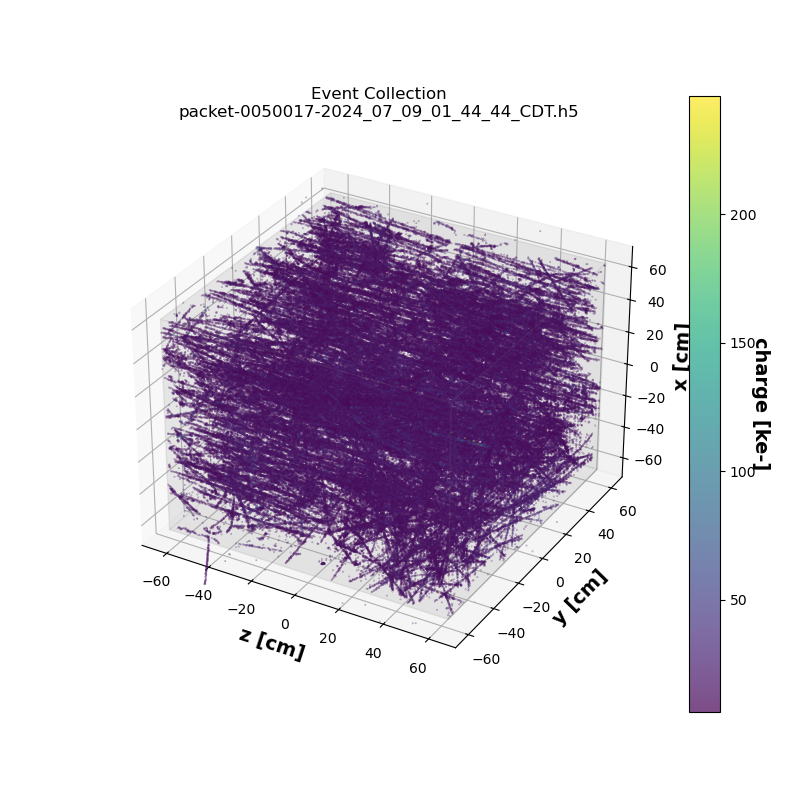

In [62]:
#interesting = [1270, 789, 1312, 290, 302, 836, 848, 903, 945, 983, 1500]
#print(sorted(interesting))
display(ff, evs)


In [ ]:
hits.dtype

In [27]:
event=58
events = ff['charge/events/data']
events_hits_ref = ff['charge/events/ref/charge/calib_prompt_hits/ref']
events_trig_ref = ff['charge/events/ref/charge/ext_trigs/ref']
events_hits_rref = ff['charge/events/ref/charge/calib_prompt_hits/ref_region']
events_trig_rref = ff['charge/events/ref/charge/ext_trigs/ref_region']
    
hits=dereference(event, events_hits_ref, ff['charge/calib_prompt_hits/data'], region=events_hits_rref)
packets=dereference(event, events_hits_ref, ff['charge/packets/data'], region=events_hits_rref)

In [ ]:
hits.flatten().shape

In [ ]:
sorted(os.listdir(ddir))

In [34]:
fp=h5py.File('/global/cfs/cdirs/dune/www/data/2x2/sandbox/v2/charge_data/packet_files/packet-0050017-2024_07_09_01_44_44_CDT.h5')

In [37]:
set(fp['packets']['io_group'])

{1, 2, 3, 4, 5, 6, 7, 8}

In [38]:
for i in range(1,9):
    print(i, sum(fp['packets']['io_group']==i))

1 2148584
2 2246806
3 2508080
4 2336235
5 3451031
6 2516229
7 2589236
8 2275809
